# Load Constrained Wake Steering Optimization

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/wake_steering_and_loads.ipynb) (requires google account)


## Install TopFarm and PyWake

In [1]:
%%capture
try:
    import py_wake
except:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git@setup_for_surrogate
try:
    import topfarm
except:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git@opt_course

## Import section

In [2]:
import numpy as np
from numpy import newaxis as na
import time

from topfarm.cost_models.cost_model_wrappers import AEPMaxLoadCostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm import TopFarmProblem
from topfarm.plotting import NoPlot

from py_wake.examples.data.lillgrund import LillgrundSite
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian, NiayifarGaussian
from py_wake.turbulence_models.stf import STF2017TurbulenceModel
from py_wake.examples.data.iea34_130rwt import IEA34_130_1WT_Surrogate 
from py_wake.deflection_models.jimenez import JimenezWakeDeflection
from py_wake.superposition_models import MaxSum
from py_wake.wind_turbines.power_ct_functions import SimpleYawModel

## Select site, turbines, wake model and additional models and set up PyWake objects

In [3]:
site = LillgrundSite()
windTurbines = IEA34_130_1WT_Surrogate()
wfm = IEA37SimpleBastankhahGaussian(site, windTurbines,deflectionModel=JimenezWakeDeflection(), turbulenceModel=STF2017TurbulenceModel(addedTurbulenceSuperpositionModel=MaxSum()))

## Choose flow cases 
 (this will determine the speed and accuracy of the simulation). In this example we will focus on only a few flow cases.

In [5]:
wsp = np.asarray([10, 15])
wdir = np.asarray([90])

## Constrain loads
 In this example we will calculate nominal loads (without yaw) and use this as a basis for the load constraint.

In [6]:
x, y = site.initial_position.T
#keeping only every second turbine as lillegrund turbines are approx. half the size of the iea 3.4MW
x = x[::2]
y = y[::2]
n_wt = x.size
i = n_wt
k = wsp.size
l = wdir.size
yaw_zero = np.zeros((i, l, k))
load_fact = 1.02
simulationResult = wfm(x,y,wd=wdir, ws=wsp, yaw=yaw_zero)
nom_loads = simulationResult.loads('OneWT')['LDEL'].values
max_loads = nom_loads * load_fact

## Configure the optimization
 this includes e.g. selection of maximum number of iterations, convergence tolerance, optimizer algorithm and design variable boundaries

In [7]:
maxiter = 5
driver = EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter)
yaw_min, yaw_max =  - 40, 40
yaw_init = np.zeros((i, l, k))
tol = 1e-8
ec = 1e-4
step = 1e-2

## Setup cost function

In [8]:
def aep_load_func(yaw_ilk):
    simres = wfm(x, y, wd=wdir, ws=wsp, yaw=yaw_ilk)
    aep = simres.aep().sum()
    loads = simres.loads('OneWT')['LDEL'].values
    return aep, loads

## Setup gradient function
 For some problems it is sufficient to rely on the automatic finite difference calculated by OpenMDAO or you can specify the explicit gradients from your model. In this case we don't have explicit gradients but the automatic finite difference is also inefficient so we do a manual population of the Jacobian

In [9]:
s = nom_loads.shape[0]
P_ilk = np.broadcast_to(simulationResult.P.values[na], (i, l, k))
lifetime = float(60 * 60 * 24 * 365 * 20)
f1zh = 10.0 ** 7.0
lifetime_on_f1zh = lifetime / f1zh
indices = np.arange(i * l * k).reshape((i, l, k))

def aep_load_gradient(yaw_ilk):
    simres0 = wfm(x, y, wd=wdir, ws=wsp, yaw=yaw_ilk)
    aep0 = simres0.aep()
    DEL0 = simulationResult.loads('OneWT')['DEL'].values
    LDEL0 = simulationResult.loads('OneWT')['LDEL'].values
    d_aep_d_yaw = np.zeros(i*l*k)
    d_load_d_yaw = np.zeros((s * i, i * l * k))
    for n in range(n_wt):
        yaw_step = yaw_ilk.copy()
        yaw_step = yaw_step.reshape(i, l, k)
        yaw_step[n, :, :] += step
        simres_fd = wfm(x, y, wd=wdir, ws=wsp, yaw=yaw_step)
        aep_fd = simres_fd.aep()
        d_aep_d_yaw[n * l * k : (n + 1) * l * k] = (((aep_fd.values - aep0.values) / step).sum((0))).ravel()
        
        DEL_fd = simres_fd.loads('OneWT')['DEL'].values
        for _ls in range(s):
            m = simulationResult.loads('OneWT').m.values[_ls]
            for _wd in range(l):
                for _ws in range(k):
                    DEL_fd_fc = DEL0.copy()
                    DEL_fd_fc[:, :, _wd, _ws] = DEL_fd[:, :, _wd, _ws]
                    DEL_fd_fc = DEL_fd_fc[_ls, :, :, :]
                    f = DEL_fd_fc.mean()
                    LDEL_fd = (((P_ilk * (DEL_fd_fc/f) ** m).sum((1, 2)) * lifetime_on_f1zh) ** (1/m))*f
                    d_load_d_yaw[n_wt * _ls : n_wt * (_ls + 1), indices[n, _wd, _ws]] = (LDEL_fd - LDEL0[_ls]) / step

    return d_aep_d_yaw, d_load_d_yaw

## Wrap your pure python cost and gradient functions in a topfarm component

In [10]:
cost_comp = AEPMaxLoadCostModelComponent(input_keys=[('yaw_ilk', np.zeros((i, l, k)))],
                                          n_wt = n_wt,
                                          aep_load_function = aep_load_func,
                                          aep_load_gradient = aep_load_gradient,
                                          max_loads = max_loads, 
                                          objective=True,
                                          income_model=True,
                                          output_keys=[('AEP', 0), ('loads', np.zeros((s, i)))]
                                          )

## Set up the TopFarm problem

In [11]:
problem = TopFarmProblem(design_vars={'yaw_ilk': (yaw_init, yaw_min, yaw_max)},
                          cost_comp=cost_comp,
                          driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
                          plot_comp=NoPlot(),
                          expected_cost=ec)

## Optimize

In [12]:
cost, state, recorder = problem.optimize()

Iteration limit reached    (Exit mode 9)
            Current function value: [-738670.14118039]
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 5
Optimization FAILED.
Iteration limit reached
-----------------------------------


## Plot results
 Try to run the commands below to watch the resulting wake map for different flow cases

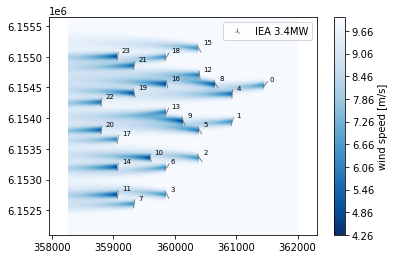

In [14]:
# simulationResult = wfm(x,y,wd=wdir[0], ws=wsp[0], yaw=state['yaw_ilk'][:,0,0])
# simulationResult.flow_map().plot_wake_map()